In [129]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Step 1: Data Preprocessing
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/ML/mm.csv')

# Tokenize the review sentences
def tokenize_review(review):
    return review.split()

data['Tokenized_Review'] = data['Reviews'].apply(tokenize_review)

In [130]:
# Create a vocabulary of unique words
vocab = set()
for review in data['Tokenized_Review']:
    vocab.update(review)

vocab_size = len(vocab)

In [131]:
# Step 2: Feature Extraction
# Convert the reviews into numerical representations using word embeddings
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data['Tokenized_Review'])

X = tokenizer.texts_to_sequences(data['Tokenized_Review'])
X = pad_sequences(X, maxlen=100, padding='post')

In [132]:
# Step 3: Sequence Labeling
# Create a dataset with word-level labels for opinion phrases
def create_opinion_labels(opinion_phrase, tokenized_review):
    labels = ['O'] * len(tokenized_review)
    if opinion_phrase in ' '.join(tokenized_review):
        opinion_tokens = opinion_phrase.split()
        for i in range(len(tokenized_review)):
            if tokenized_review[i:i+len(opinion_tokens)] == opinion_tokens:
                labels[i] = 'B-OPINION'
                for j in range(1, len(opinion_tokens)):
                    labels[i+j] = 'I-OPINION'
    return labels

data['Opinion_Labels'] = data.apply(lambda row: create_opinion_labels(row['Opinion_Phrases'], row['Tokenized_Review']), axis=1)

# Convert the labels into numerical representations
label_mapping = {'O': 0, 'B-OPINION': 1, 'I-OPINION': 2}
y = [[label_mapping[label] for label in labels] for labels in data['Opinion_Labels']]
y = pad_sequences(y, maxlen=100, padding='post')


In [133]:
data['Opinion_Labels']

0       [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
1       [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
2       [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
3       [O, O, O, O, O, B-OPINION, I-OPINION, I-OPINIO...
4       [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
                              ...                        
3536    [O, O, O, O, O, O, O, O, O, O, O, O, O, B-OPIN...
3537    [O, O, O, O, O, O, O, B-OPINION, I-OPINION, I-...
3538    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
3539    [O, O, B-OPINION, I-OPINION, I-OPINION, O, O, ...
3540    [O, B-OPINION, I-OPINION, I-OPINION, I-OPINION...
Name: Opinion_Labels, Length: 3541, dtype: object

In [134]:
data.head(5)

,Opinion_Phrases,Relevant_Words,Sentiment_Expressions,Aspect,Product,Sentiment,Reviews,Tokenized_Review,Opinion_Labels
0,"cordwire somehow ""create"" noise","am, sending, wearing, create, interferes, list...",different,wire,earphone,NEGATIVE,"Unfortunately, I am sending them back for 2 di...","[Unfortunately,, I, am, sending, them, back, f...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,wire rub across the collar,"turn, listens, created, moving, see, mean, is,...",bad,wire,earphone,NEGATIVE,If you turn the music off completely and then ...,"[If, you, turn, the, music, off, completely, a...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,wire under your chin,"do, have, is, run, tighten",bad,wire,earphone,NEGATIVE,"I do however have some pain points: First, the...","[I, do, however, have, some, pain, points:, Fi...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,wire got torn,"Sounds, got, torn, cause, gets",right,wire,earphone,NEGATIVE,"Sounds like one of the wire got torn , caus...","[Sounds, like, one, of, the, wire, got, torn, ...","[O, O, O, O, O, B-OPINION, I-OPINION, I-OPINIO..."
4,"innards are exposed, wire","came, are, exposed","actual, black",wire,earphone,NEGATIVE,The silver part with the actual speaker came l...,"[The, silver, part, with, the, actual, speaker...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [135]:
# Step 4: Model Architecture
# Define the model architecture

def create_model(vocab_size, embedding_dim=100, lstm_units=32, dropout_rate=0.5):
    input_layer = Input(shape=(100,))
    embedding_layer = Embedding(vocab_size, embedding_dim)(input_layer)
    bilstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate))(embedding_layer)
    dropout_layer = TimeDistributed(Dropout(dropout_rate))(bilstm_layer)
    output_layer = TimeDistributed(Dense(3, activation='softmax'))(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model



In [136]:
# Step 5: K-Fold Cross-Validation

from sklearn.model_selection import KFold

k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)



# Split the data into features (X) and labels (y)
X = data['Tokenized_Review'].tolist()
y = data['Opinion_Labels'].tolist()

# Convert the labels into numerical representations
label_mapping = {'O': 0, 'B-OPINION': 1, 'I-OPINION': 2}
y = [[label_mapping[label] for label in labels] for labels in y]

# Pad the sequences
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=100, padding='post')
y = pad_sequences(y, maxlen=100, padding='post')

# Variables to store metrics across folds
accuracies = []
precisions = []
recalls = []
f1_scores = []

Epoch 1/5
34/34 [==============================] - 34s 790ms/step - loss: 0.1917 - accuracy: 0.9389 - val_loss: 0.0816 - val_accuracy: 0.9685
Epoch 2/5
34/34 [==============================] - 27s 797ms/step - loss: 0.0673 - accuracy: 0.9745 - val_loss: 0.0669 - val_accuracy: 0.9759
Epoch 3/5
34/34 [==============================] - 26s 767ms/step - loss: 0.0483 - accuracy: 0.9822 - val_loss: 0.0595 - val_accuracy: 0.9785
Epoch 4/5
34/34 [==============================] - 25s 741ms/step - loss: 0.0361 - accuracy: 0.9871 - val_loss: 0.0556 - val_accuracy: 0.9813
Epoch 5/5
23/23 [==============================] - 3s 115ms/step - loss: 0.0518 - accuracy: 0.9822
Test Loss: 0.0518
Test Accuracy: 0.9822
23/23 [==============================] - 2s 58ms/step


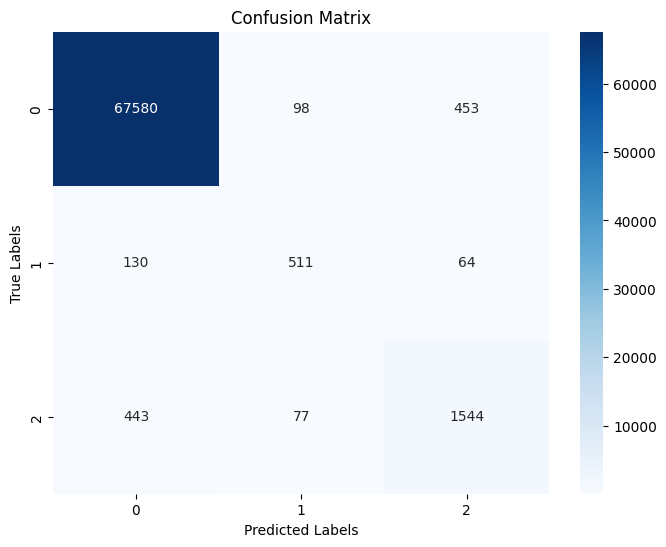

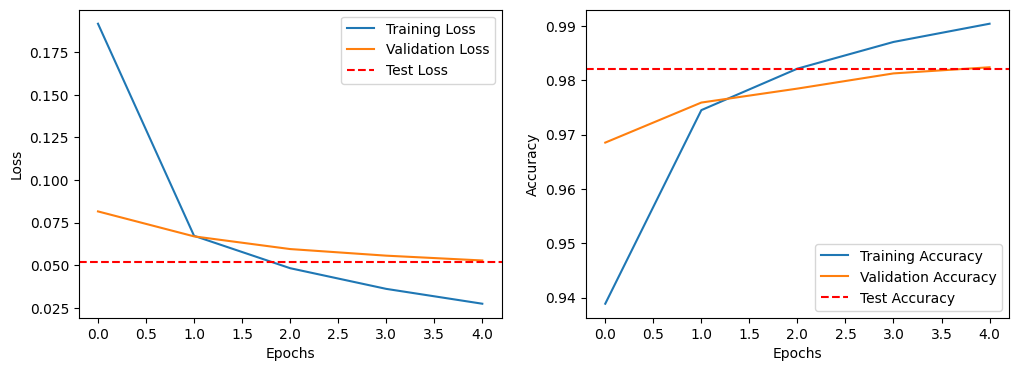

Epoch 1/5
34/34 [==============================] - 33s 758ms/step - loss: 0.1891 - accuracy: 0.9406 - val_loss: 0.0850 - val_accuracy: 0.9682
Epoch 2/5
34/34 [==============================] - 25s 710ms/step - loss: 0.0697 - accuracy: 0.9739 - val_loss: 0.0641 - val_accuracy: 0.9778
Epoch 3/5
34/34 [==============================] - 25s 723ms/step - loss: 0.0481 - accuracy: 0.9824 - val_loss: 0.0525 - val_accuracy: 0.9816
Epoch 4/5
34/34 [==============================] - 26s 753ms/step - loss: 0.0343 - accuracy: 0.9878 - val_loss: 0.0454 - val_accuracy: 0.9839
Epoch 5/5
23/23 [==============================] - 1s 58ms/step - loss: 0.0530 - accuracy: 0.9826
Test Loss: 0.0530
Test Accuracy: 0.9826
23/23 [==============================] - 2s 76ms/step


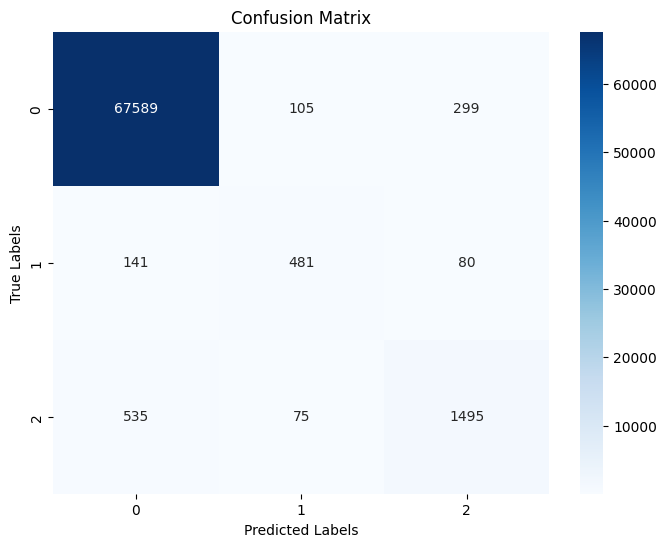

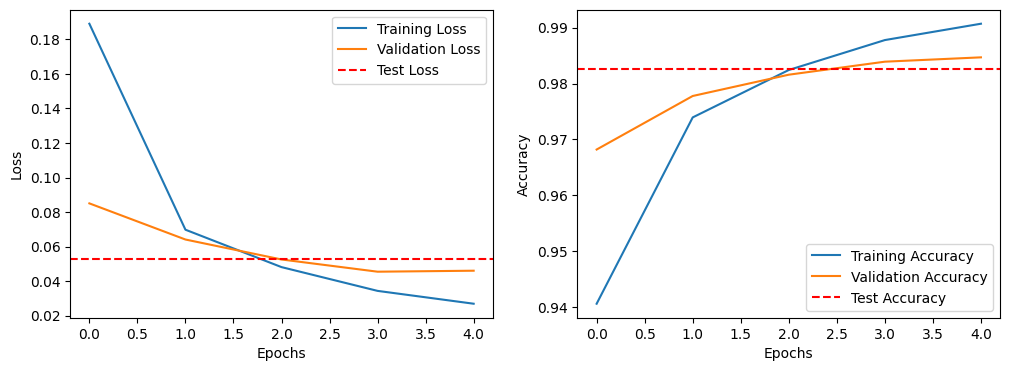

Epoch 1/5
34/34 [==============================] - 34s 813ms/step - loss: 0.1877 - accuracy: 0.9410 - val_loss: 0.0788 - val_accuracy: 0.9691
Epoch 2/5
34/34 [==============================] - 28s 843ms/step - loss: 0.0681 - accuracy: 0.9741 - val_loss: 0.0636 - val_accuracy: 0.9772
Epoch 3/5
34/34 [==============================] - 27s 774ms/step - loss: 0.0463 - accuracy: 0.9831 - val_loss: 0.0580 - val_accuracy: 0.9795
Epoch 4/5
34/34 [==============================] - 26s 751ms/step - loss: 0.0318 - accuracy: 0.9885 - val_loss: 0.0525 - val_accuracy: 0.9818
Epoch 5/5
23/23 [==============================] - 1s 59ms/step - loss: 0.0528 - accuracy: 0.9836
Test Loss: 0.0528
Test Accuracy: 0.9836
23/23 [==============================] - 2s 59ms/step


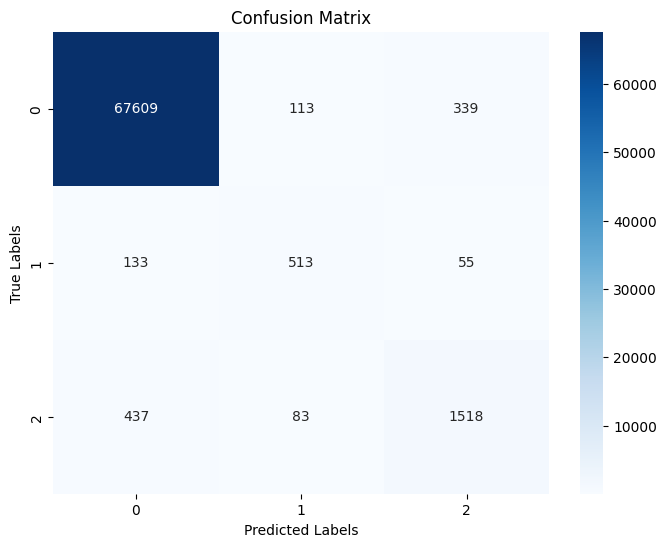

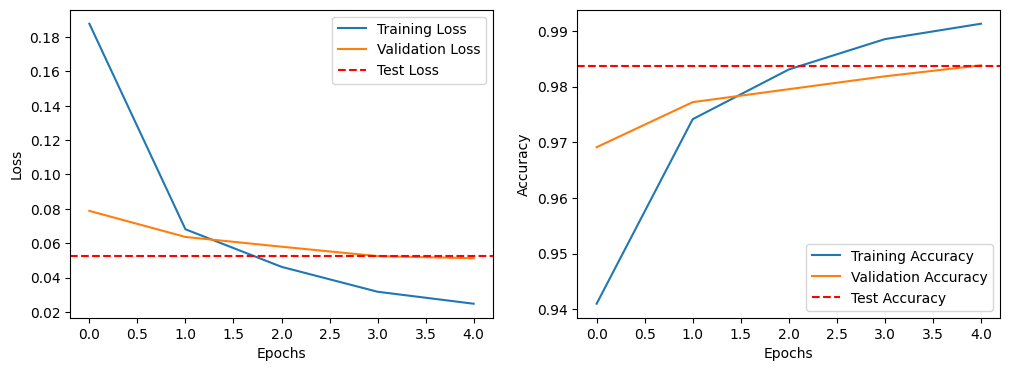

Epoch 1/5
34/34 [==============================] - 34s 814ms/step - loss: 0.1991 - accuracy: 0.9370 - val_loss: 0.0820 - val_accuracy: 0.9687
Epoch 2/5
34/34 [==============================] - 26s 760ms/step - loss: 0.0666 - accuracy: 0.9751 - val_loss: 0.0549 - val_accuracy: 0.9808
Epoch 3/5
34/34 [==============================] - 26s 764ms/step - loss: 0.0404 - accuracy: 0.9853 - val_loss: 0.0481 - val_accuracy: 0.9838
Epoch 4/5
34/34 [==============================] - 27s 802ms/step - loss: 0.0298 - accuracy: 0.9894 - val_loss: 0.0477 - val_accuracy: 0.9839
Epoch 5/5
23/23 [==============================] - 2s 86ms/step - loss: 0.0546 - accuracy: 0.9821
Test Loss: 0.0546
Test Accuracy: 0.9821
23/23 [==============================] - 2s 57ms/step


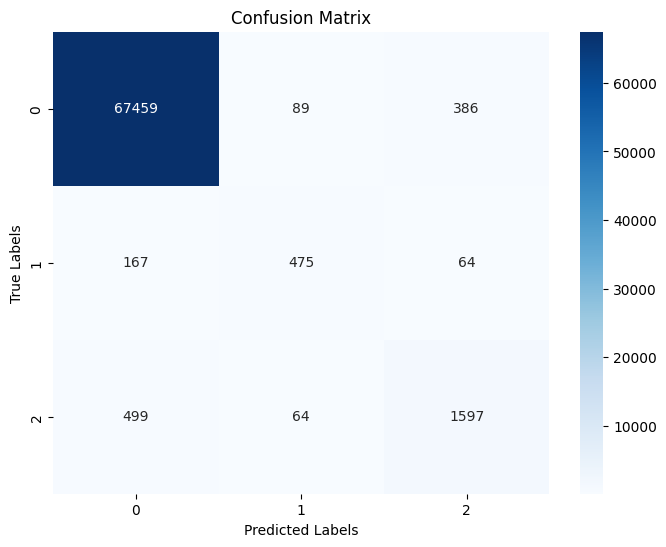

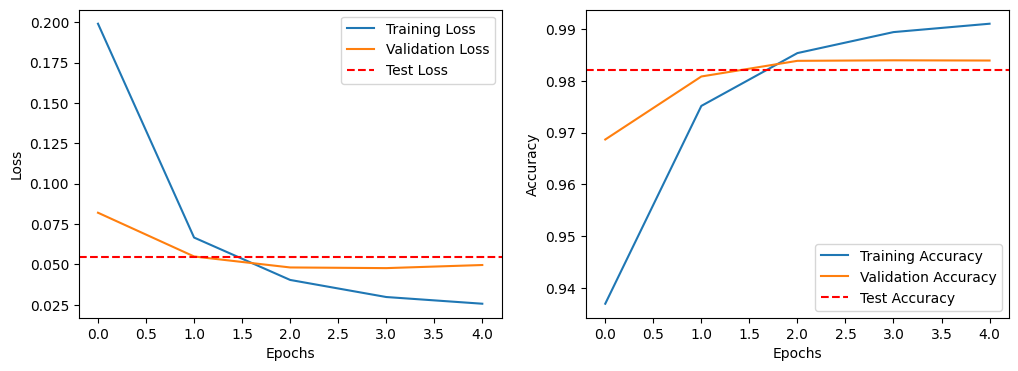

Epoch 1/5
34/34 [==============================] - 35s 786ms/step - loss: 0.1769 - accuracy: 0.9480 - val_loss: 0.0854 - val_accuracy: 0.9682
Epoch 2/5
34/34 [==============================] - 25s 729ms/step - loss: 0.0660 - accuracy: 0.9749 - val_loss: 0.0678 - val_accuracy: 0.9764
Epoch 3/5
34/34 [==============================] - 25s 730ms/step - loss: 0.0431 - accuracy: 0.9839 - val_loss: 0.0558 - val_accuracy: 0.9813
Epoch 4/5
34/34 [==============================] - 25s 729ms/step - loss: 0.0311 - accuracy: 0.9891 - val_loss: 0.0518 - val_accuracy: 0.9835
Epoch 5/5
23/23 [==============================] - 1s 61ms/step - loss: 0.0563 - accuracy: 0.9816
Test Loss: 0.0563
Test Accuracy: 0.9816
23/23 [==============================] - 2s 86ms/step


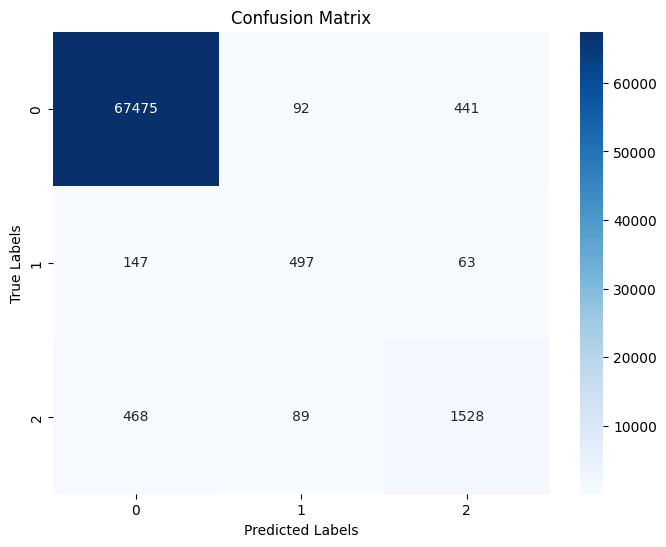

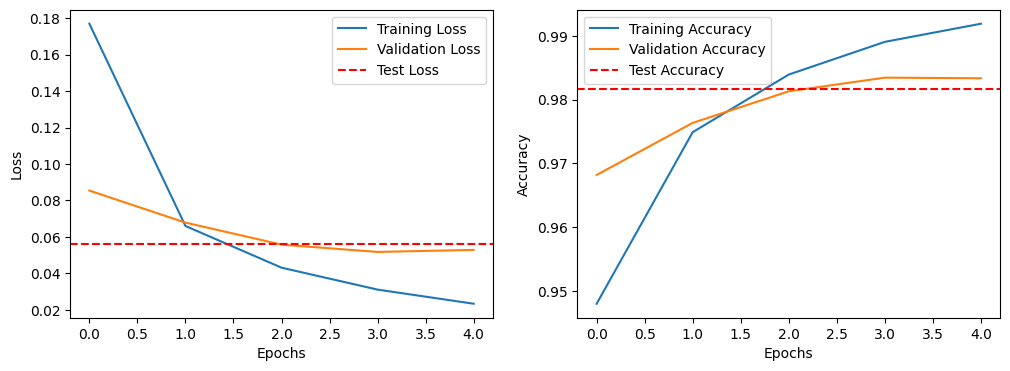

In [137]:
# Step 6: Model Training and Evaluation

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns


# Perform k-fold cross-validation
for train_index, test_index in kfold.split(X, y):
    # Split the data into train, validation, and test sets
    X_train_val, X_test = X[train_index], X[test_index]
    y_train_val, y_test = y[train_index], y[test_index]

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

    # Create and train the model
    model = create_model(vocab_size)
    history = model.fit(X_train, np.array(y_train), validation_data=(X_val, np.array(y_val)), epochs=5, batch_size=64)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, np.array(y_test))
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Predict labels for the test set
    predictions = model.predict(X_test)
    predicted_labels = np.argmax(predictions, axis=-1)

    # Flatten the true labels and predicted labels
    true_labels = [label for sublist in y_test for label in sublist]
    predicted_labels = [label for sublist in predicted_labels for label in sublist]

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')
    f1 = f1_score(true_labels, predicted_labels, average='micro')

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot training vs validation loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.axhline(test_loss, color='red', linestyle='--', label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.axhline(test_accuracy, color='red', linestyle='--', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



In [138]:
# Print average metrics across folds
print("Average Accuracy:", np.mean(accuracies))
print("Average Precision:", np.mean(precisions))
print("Average Recall:", np.mean(recalls))
print("Average F1-score:", np.mean(f1_scores))

Average Accuracy: 0.9824089949240197
Average Precision: 0.9824089949240197
Average Recall: 0.9824089949240197
Average F1-score: 0.9824089949240197


In [139]:
# Aspect and Product Prediction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# Aspect prediction
aspect_vectorizer = TfidfVectorizer()
aspect_features = aspect_vectorizer.fit_transform(data['Reviews'])
aspect_labels = data['Aspect']

aspect_classifier = LinearSVC()
aspect_classifier.fit(aspect_features, aspect_labels)

# Product prediction
product_vectorizer = TfidfVectorizer()
product_features = product_vectorizer.fit_transform(data['Reviews'])
product_labels = data['Product']

product_classifier = LinearSVC()
product_classifier.fit(product_features, product_labels)

LinearSVC()

In [140]:
# Step 8: Inference Functions
# Inference function for opinion phrase prediction

def predict_opinion_phrase(review):
    # Tokenize the review
    tokenized_review = tokenize_review(review)

    # Encode the tokenized review
    encoded_review = tokenizer.texts_to_sequences([tokenized_review])
    padded_review = pad_sequences(encoded_review, maxlen=100, padding='post')

    # Predict the opinion phrase labels
    predictions = model.predict(padded_review)
    predicted_labels = np.argmax(predictions, axis=-1)

    # Extract the opinion phrase
    opinion_phrase = []
    for token, label in zip(tokenized_review, predicted_labels[0]):
        if label == 1:  # B-OPINION
            opinion_phrase.append(token)
        elif label == 2:  # I-OPINION
            opinion_phrase.append(token)
        else:  # O
            if opinion_phrase:
                break

    return ' '.join(opinion_phrase)

# Inference function for aspect and product prediction
def predict_aspect_and_product(review):
    # Encode the review using the aspect and product vectorizers
    aspect_features = aspect_vectorizer.transform([review])
    product_features = product_vectorizer.transform([review])

    # Predict the aspect and product
    predicted_aspect = aspect_classifier.predict(aspect_features)[0]
    predicted_product = product_classifier.predict(product_features)[0]

    return predicted_aspect, predicted_product

### **Testing for Reviews present in dataset**

In [141]:
# Example usage
new_review = "Also after only a few days of light use, the scroll   wheel is now very loose   (in click mode).  "

# Predict the opinion phrase
predicted_opinion_phrase = predict_opinion_phrase(new_review)
print("Predicted Opinion Phrase:", predicted_opinion_phrase)

# Predict the aspect and product
predicted_aspect, predicted_product = predict_aspect_and_product(new_review)
print("Predicted Aspect:", predicted_aspect)
print("Predicted Product:", predicted_product)

1/1 [==============================] - 0s 127ms/step
Predicted Opinion Phrase: wheel is now very loose
Predicted Aspect: wheel
Predicted Product: mouse


In [142]:
# Example usage
new_review = "Sounds like one of the   wire got torn  , cause the right ear sometimes gets no sound.  "

# Predict the opinion phrase
predicted_opinion_phrase = predict_opinion_phrase(new_review)
print("Predicted Opinion Phrase:", predicted_opinion_phrase)

# Predict the aspect and product
predicted_aspect, predicted_product = predict_aspect_and_product(new_review)
print("Predicted Aspect:", predicted_aspect)
print("Predicted Product:", predicted_product)

1/1 [==============================] - 0s 73ms/step
Predicted Opinion Phrase: wire got torn
Predicted Aspect: wire
Predicted Product: earphone


In [143]:
# Example usage
new_review = "The womans   voice is still too loud   and there is no volume control on the device. "

# Predict the opinion phrase
predicted_opinion_phrase = predict_opinion_phrase(new_review)
print("Predicted Opinion Phrase:", predicted_opinion_phrase)

# Predict the aspect and product
predicted_aspect, predicted_product = predict_aspect_and_product(new_review)
print("Predicted Aspect:", predicted_aspect)
print("Predicted Product:", predicted_product)

1/1 [==============================] - 0s 90ms/step
Predicted Opinion Phrase: voice is still too loud
Predicted Aspect: voice
Predicted Product: gps


### **For the sample reviews from the dataset, the model predicted the opinion phrase, aspect and product correctly**

### **Changing the position of the opinion in the reviews earlier used**

In [144]:
# Example usage
new_review = "wheel is now very loose also after only a few days of light use, the scroll   (in click mode).  "

# Predict the opinion phrase
predicted_opinion_phrase = predict_opinion_phrase(new_review)
print("Predicted Opinion Phrase:", predicted_opinion_phrase)

# Predict the aspect and product
predicted_aspect, predicted_product = predict_aspect_and_product(new_review)
print("Predicted Aspect:", predicted_aspect)
print("Predicted Product:", predicted_product)

1/1 [==============================] - 0s 73ms/step
Predicted Opinion Phrase: wheel is now very loose
Predicted Aspect: wheel
Predicted Product: mouse


In [145]:
# Example usage
new_review = "the right ear sometimes gets no sound. Sounds like one of the wire got torn   "

# Predict the opinion phrase
predicted_opinion_phrase = predict_opinion_phrase(new_review)
print("Predicted Opinion Phrase:", predicted_opinion_phrase)

# Predict the aspect and product
predicted_aspect, predicted_product = predict_aspect_and_product(new_review)
print("Predicted Aspect:", predicted_aspect)
print("Predicted Product:", predicted_product)

1/1 [==============================] - 0s 92ms/step
Predicted Opinion Phrase: wire got torn
Predicted Aspect: wire
Predicted Product: earphone


In [146]:
# Example usage
new_review = "there is no volume control on the device and the womans   voice is still too loud "

# Predict the opinion phrase
predicted_opinion_phrase = predict_opinion_phrase(new_review)
print("Predicted Opinion Phrase:", predicted_opinion_phrase)

# Predict the aspect and product
predicted_aspect, predicted_product = predict_aspect_and_product(new_review)
print("Predicted Aspect:", predicted_aspect)
print("Predicted Product:", predicted_product)

1/1 [==============================] - 0s 104ms/step
Predicted Opinion Phrase: voice is still too loud
Predicted Aspect: voice
Predicted Product: gps


### **Even when the position of the opinion phrase is changed and the review is structured in a meaningful way, the model is able to identify the opinion phrase, aspect and product correctly**

## **Checking for new reviews which are not present in the dataset**

In [147]:
# Example usage
new_review = "keyboard is big and comfortable to use. But the keys are placed close together"

# Predict the opinion phrase
predicted_opinion_phrase = predict_opinion_phrase(new_review)
print("Predicted Opinion Phrase:", predicted_opinion_phrase)

# Predict the aspect and product
predicted_aspect, predicted_product = predict_aspect_and_product(new_review)
print("Predicted Aspect:", predicted_aspect)
print("Predicted Product:", predicted_product)

1/1 [==============================] - 0s 78ms/step
Predicted Opinion Phrase: keys are placed close
Predicted Aspect: keys
Predicted Product: keyboard


In [148]:
# Example usage
new_review = "The song quality is good but the display on the screen is not clear."

# Predict the opinion phrase
predicted_opinion_phrase = predict_opinion_phrase(new_review)
print("Predicted Opinion Phrase:", predicted_opinion_phrase)

# Predict the aspect and product
predicted_aspect, predicted_product = predict_aspect_and_product(new_review)
print("Predicted Aspect:", predicted_aspect)
print("Predicted Product:", predicted_product)

1/1 [==============================] - 0s 125ms/step
Predicted Opinion Phrase: screen is not clear.
Predicted Aspect: screen
Predicted Product: mp3_player


In [149]:
# Example usage
new_review = "The signal strength is too low and it requires reboot all the time"

# Predict the opinion phrase
predicted_opinion_phrase = predict_opinion_phrase(new_review)
print("Predicted Opinion Phrase:", predicted_opinion_phrase)

# Predict the aspect and product
predicted_aspect, predicted_product = predict_aspect_and_product(new_review)
print("Predicted Aspect:", predicted_aspect)
print("Predicted Product:", predicted_product)

1/1 [==============================] - 0s 75ms/step
Predicted Opinion Phrase: signal strength is too low
Predicted Aspect: signal
Predicted Product: router


## **The model is capable of extracting the opinion phrase, aspect and product for a new unseen review.**